In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geocube.api.core import make_geocube
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from shapely.geometry import Point
import xarray as xr

In [2]:
pd.set_option('display.max_rows', 500)

#### Auxiliary functions

In [3]:
# Gets zones
def get_zones(raster, vector, varname, keyname='region_code'):
    """
    Attributes each grid cell of a raster to a unique ID based on intersection with vector polygons. The function 
    allows to optionally include time as a coordinate and also returns a correspondence dictionary for easier access.
    
    Parameters
    ----------
    raster : xr.DataArray
        The input raster data. 
    vector : gpd.GeoDataFrame
        The input vector data. It should be filtered and have the keyname column assigned.
    varname : str
        The name of the variable in the raster to use in the output grid – 
    keyname : str, optional
        A string representing the column values that will be added to the output grid, 
        marking to which polygon each pixel belongs. Defaults to 'region_code'.

    
    Returns
    -------
    outgrid : xr.Dataset
        The output grid with grid cells marked with unique IDs. If 'time' is True, time is also included as a coordinate.
    corresp : dict
        A correspondence dictionary mapping unique polygon IDs to the respective 'keyname' values for easy access.
        
    Notes
    -----
    This docstring was created with the help of GPT-4, an AI language model developed by OpenAI.
    """

    
    # Saves the for afterwards
    time_dim = raster.time
    
    # Keeps only the variable of interest
    raster = raster[varname]
        
    # Creates a key to mark the grid cells with
    vector[keyname] = range(0, vector.shape[0]) # in geocube, the ids need to be numbers :/
      
    # A correspondence dict for easier access
    corresp = {row["NUTS_ID"]: row[keyname] for index, row in vector[[keyname, 'NUTS_ID']].iterrows()}
    
    # Creates an output grid – that is, an xarray representation of the vector data
    # but with no values associated
    outgrid = make_geocube(
        vector_data=vector, # The shapes that we will use as a mold
        measurements=[keyname], # This is the LABEL we will stamp the pixels with
        like=raster, # The new cube will have the shape of the raster
    )
    
    return outgrid, corresp

In [4]:
def min_max_normalize(arr, min_val=0, max_val=1, cap_min=None, cap_max=None):
    """
    Normalizes an array to a specified range [min_val, max_val].
    Optionally caps values with cap_min and cap_max before normalization.
    If the min and max in the array are the same, returns an array filled with the midpoint of min_val and max_val.
    
    This is used to adjust the opacity of the dots.
    """
    
    if cap_min is not None:
        arr = np.where(arr < cap_min, cap_min, arr)
    if cap_max is not None:
        arr = np.where(arr > cap_max, cap_max, arr)

    min_arr = cap_min if cap_min is not None else np.min(arr)
    max_arr = cap_max if cap_max is not None else np.max(arr)
    
    if min_arr == max_arr:
        return np.full(arr.shape, (min_val + max_val) / 2)
    else:
        return min_val + (arr - min_arr) * (max_val - min_val) / (max_arr - min_arr)


In [5]:
def get_color(val, threshold=None):
    """
    Returns a color code based on the input value.
    - Below 5: blue (#00a5ff)
    - 5 to 9: yellow (#dee500) or (#f0c80f, less bright)
    - 10 to 14: orange (#eb6e14)
    - 15 and above: red (#be232d)
    
    If threshold is specified, all values over the threshold are
    colored to dark grey and the others as light grey
    """
    
    
    if not threshold:
        
        if val < 5:
            return '#00a5ff' # blue 1
        elif 5 <= val < 10:
            return '#f0c80f' #'#dee500' # yellow
        elif 10 <= val < 15:
            return '#eb6e14' # orange
        elif 15 <= val < 20: 
            return '#be232d' # red
        else: # 20+
            return '#770001' # brown red computed on datawrapper
        
    else:
        
        if val < threshold:
            return "#96be00" # green
        else:
            return '#d44820'# orange

In [6]:
def add_cities(ax):
    """
    Plots the points for selected cities over the map, showing both a marker
    and the city name.

    Args:

    points (str): Path to a CSV file containing latitude, longitude, and city name
    ax (matplotlib.axes._subplots.AxesSubplot): The axes to plot the cities on
    """

    # Read the CSV file
    cities_df = pd.read_csv("../data/LAU_Centers/lau_2020_nuts_2021_pop_2018_p_2_adjusted_intersection.csv")


    # Create a GeoDataFrame using the latitude and longitude
    geometry = [Point(xy) for xy in zip(cities_df.longitude, cities_df.latitude)]
    cities_gdf = gpd.GeoDataFrame(cities_df, geometry=geometry)

    # Plot the city markers
    cities_gdf.plot(marker='o', color='black', markersize=5, ax=ax)

    # Annotate the city names
    for x, y, label in zip(cities_df.longitude, cities_df.latitude, cities_df.lau_name):
        ax.text(x, y, label, fontsize=12)


In [12]:
def plot_map(gdf, fname, size_caps=None):
    """
    Plots a map with pollution levels, using GeoDataFrame (gdf) and size caps for population scaling.

    Args:
        gdf (GeoDataFrame): GeoDataFrame containing coordinates and pollution levels.
        size_caps (tuple, optional): Min and max size caps for population scaling. If None, defaults are used.
        threshold (None or int): Specifies if a boolean threshold should be used for coloring the map. Defaults to None.

    The map will be color-coded based on pollution levels and will use population for marker scaling.
    """

    # Set up the plot with Cartopy's PlateCarree projection
    fig, ax = plt.subplots(1, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set the background color
    ax.set_facecolor("#f1f3f5") # dw gray

    # Add the country boundaries feature from Cartopy
    countries = cfeature.NaturalEarthFeature(category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='#e4e8eb')
                                             #edgecolor='#323c45')
    ax.add_feature(countries)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5, zorder=9999)
    ax.add_feature(cfeature.COASTLINE, zorder=9999)

    ax.set_ylim(gdf.y.min(), gdf.y.max())
    ax.set_xlim(gdf.x.min(), gdf.x.max())


    
    if not size_caps:
        gdf['population_scale'] = min_max_normalize(gdf['population'], .03, 100, cap_min=10, cap_max=100000)
        gdf['population_alpha'] = min_max_normalize(gdf['population'], .1, 1, cap_min=100, cap_max=100000)
    if size_caps:
        # When adjusting size caps in smaller regions, we get rid of alpha values
        gdf['population_scale'] = min_max_normalize(gdf['population'], .01, 100, cap_min=size_caps[0], cap_max=size_caps[1])
        gdf['population_alpha'] = .8

    gdf.plot(color=gdf.color,
             edgecolor=gdf.color,
             markersize=1,#gdf.population_scale,
             alpha=gdf.population_alpha, 
             ax=ax, legend=True, legend_kwds={'label': "Pollution Level"}, zorder=9998)
    
    
    plt.box(False)
    plt.savefig(f"../viz/png/{fname}.png", transparent=True, dpi=320)
    
    # Save csv with the points
    gdf[["x", "y", "pm2p5_mean", "population"]].to_csv(f"./map-csvs/{fname}-map.csv", index=False)
    
    #add_cities(ax)

In [13]:
def plot_subset(gdf, fname, region_code):
    
    # Total pop
    pop_whole = gdf.population.sum()
    
    # Filters
    gdf = gdf[gdf.region_code==region_code]
    
    # Get country population
    pop_country = gdf.population.sum()
    
    # Gets a ratio for adjusting largest dot
    ratio = pop_country / pop_whole
    max_cap = 250000
    min_cap = 25
        
    # Max cap is adjusted by the ratio of general max cap and the total
    plot_map(gdf[gdf.region_code==region_code], size_caps=(min_cap, max_cap), fname=fname)
    

## Pixel level data

In [14]:
def make_dot_map(fname, time="2022", raster_type='forecast', region_code=None, threshold=None):
    """
    Plots a dot map of pollution levels in Europe, with an option to filter by a specific region code.

    Args:
        region_code (str, optional): The code of the region to plot. If None, the entire map of Europe is plotted.

    The function loads necessary datasets, processes the data into a GeoDataFrame, and calls either 'plot_map' 
    to display the entire map or 'plot_subset' for a specific region. It considers only populated places 
    and organizes the data by pollution levels and population.
    """
    
    # Opens pollution dataset
    raster = xr.open_dataset(f"../output/5.europe-{raster_type}-reprojected.netcdf", decode_coords='all')
    raster = raster.sel(time=time)
    raster = raster.resample(time="Y").mean().squeeze()
    
    # Opens GHSL dataset
    ghsl = xr.open_dataset(f"../output/5.ghsl-europe-{raster_type}-reprojected.netcdf", decode_coords='all').squeeze()
    
    # Opens NUTS + extra countries – country level
    nuts = gpd.read_file("../output/NUTS/expanded-NUTS.json")
    nuts = nuts[nuts.LEVL_CODE==0]
    
    # Ensures that the data is properly sorted, otherwise it could show up upside down
    raster = raster.sortby(['x', 'y'])
    ghsl = ghsl.sortby(['x', 'y'])
    
    # Gets a grid with the assigned zones and a dictionary with the numerical id -> nuts code correspondence
    outgrid, corresp = get_zones(raster, nuts, varname='pm2p5_mean')
    
    
    # Attributes region codes to CAMS
    outgrid = outgrid.assign_coords({"x": raster.x, "y": raster.y})
    raster['region_code'] = outgrid.region_code
    
    # Attributes population to each cell
    ghsl = ghsl.assign_coords({"x": raster.x, "y": raster.y})
    raster['population'] = ghsl.band_data
    
    # Make it a dataframe
    gdf = raster.to_dataframe().reset_index()
    
    # We only want to plot populated places
    gdf = gdf[gdf.population >= 100]
    # If a threshold is specified, keep only places over it
#     if threshold:
#         gdf = gdf[gdf.pm2p5_mean > threshold]
        
        
    gdf['color'] = gdf.pm2p5_mean.apply(lambda row: get_color(row, threshold=threshold))
#     display(gdf)    
    
    # Creates a geometry column
    geometry = gdf.apply(lambda row: Point(row.x, row.y), axis=1)
    gdf = gpd.GeoDataFrame(gdf, geometry=geometry)
    gdf = gdf.set_crs("EPSG:4326")
    
    
    if not region_code:
        plot_map(gdf, fname=fname)
    else:
        plot_subset(gdf, fname, corresp[region_code])

### Density and exposure map

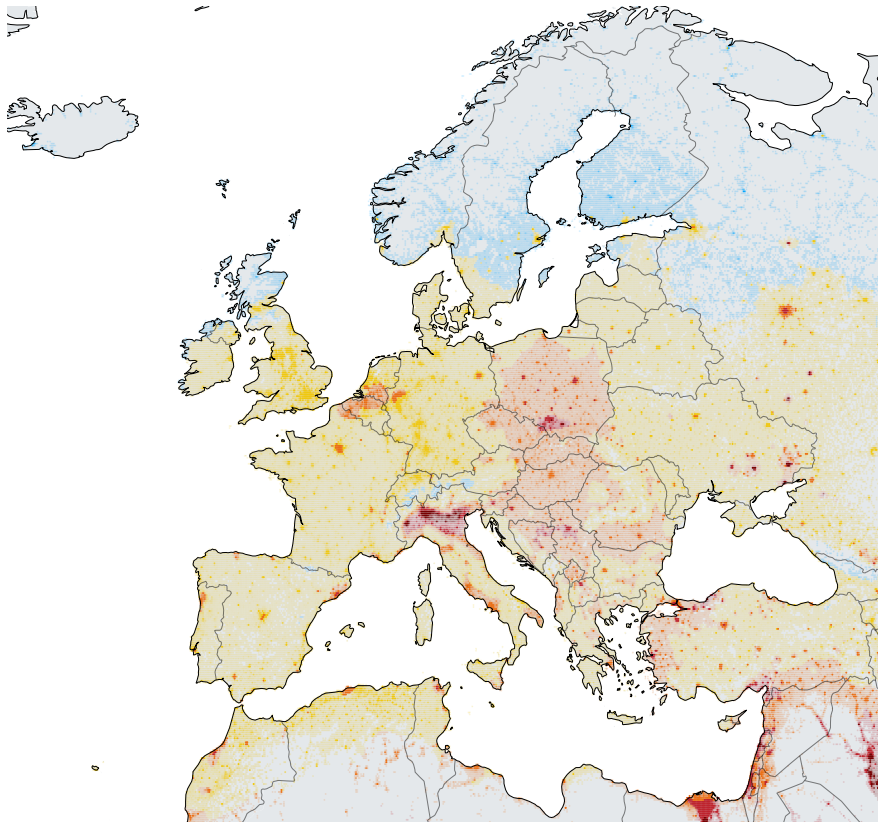

In [15]:
time = "2022"
make_dot_map(time=time, raster_type='reanalysis', fname='five-bins')

In [16]:
make_dot_map(time=time, raster_type='reanalysis', region_code='DE', name='germany')

TypeError: make_dot_map() got an unexpected keyword argument 'name'

In [ ]:
make_dot_map(time=time, raster_type='reanalysis', threshold=5, fname='treshold-5')

In [ ]:
make_dot_map(time=time, raster_type='reanalysis', threshold=10,  fname='treshold-10')

In [ ]:
make_dot_map(time=time, raster_type='reanalysis', threshold=20,  fname='treshold-20')

In [ ]:
make_dot_map(time=time, raster_type='reanalysis', threshold=25,  fname='treshold-25')